In [ ]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm

In [ ]:
class Random_Variable:

    def __init__(self, name, values, probability_distribution):
        self.name = name
        self.values = values
        self.probability_distribution = probability_distribution
        if all(type(item) is np.int64 for item in values):
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values):
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values
        else:
            self.type = 'undefined'

    def sample(self,size):
        if (self.type =='numeric'):
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'):
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples

    def probs(self):
        return self.probability_distribution

    def vals(self):
        print(self.type)
        return self.values

In [ ]:
values = ['S', 'C']
probabilities = [0.5, 0.5]
weather = Random_Variable('weather', values, probabilities)
samples = weather.sample(365)

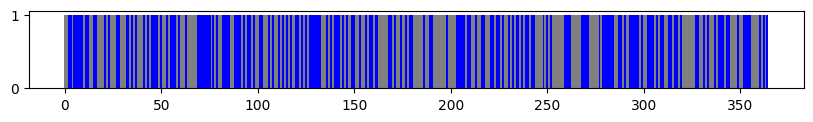

In [ ]:
state2color = {}
state2color['S'] = 'blue'
state2color['C'] = 'grey'

def plot_weather_samples(samples, state2color):
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)

plot_weather_samples(samples, state2color)

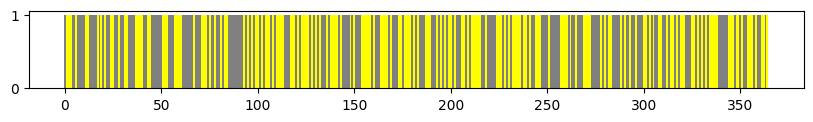

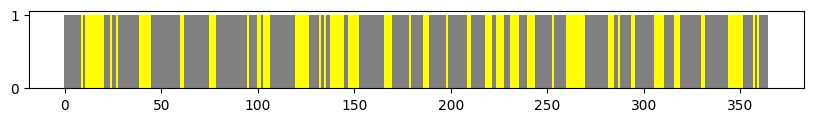

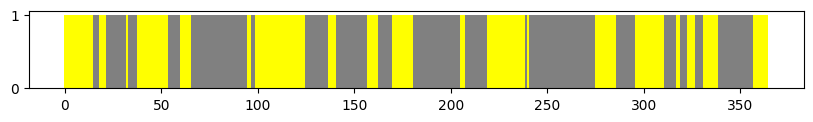

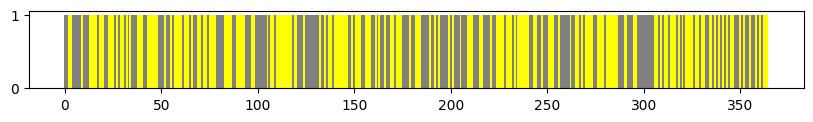

In [ ]:
def markov_chain(transmat, state, state_names, samples):
    (rows, cols) = transmat.shape
    rvs = []
    values = list(np.arange(0,rows))

    # create random variables for each row of transition matrix
    for r in range(rows):
        rv = Random_Variable("row" + str(r), values, transmat[r])
        rvs.append(rv)

    # start from initial state and then sample the appropriate
    # random variable based on the state following the transitions
    states = []
    for n in range(samples):
        state = rvs[state].sample(1)[0]
        states.append(state_names[state])
    return states


# transition matrices for the Markov Chain
transmat1 = np.array([[0.7, 0.3],
                    [0.2, 0.8]])

transmat2 = np.array([[0.9, 0.1],
                    [0.1, 0.9]])

transmat3 = np.array([[0.5, 0.5],
                     [0.5, 0.5]])



# plot the iid model too

state2color = {}
state2color['S'] = 'yellow'
state2color['C'] = 'grey'
samples = weather.sample(365)

plot_weather_samples(samples, state2color)

samples1 = markov_chain(transmat1,0,['S','C'], 365)
plot_weather_samples(samples1, state2color)

samples2 = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(samples2, state2color)

samples3 = markov_chain(transmat3,0,['S','C'], 365)
plot_weather_samples(samples3, state2color)


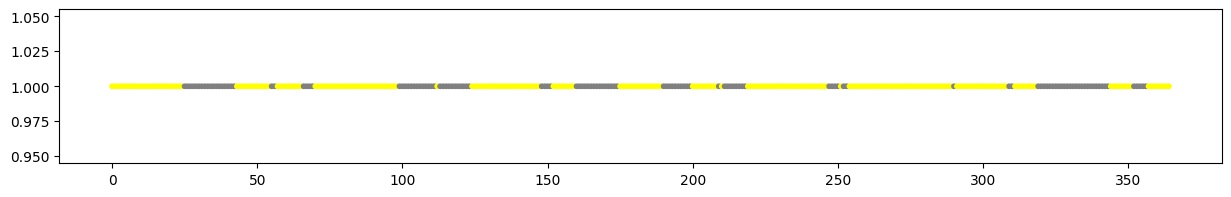

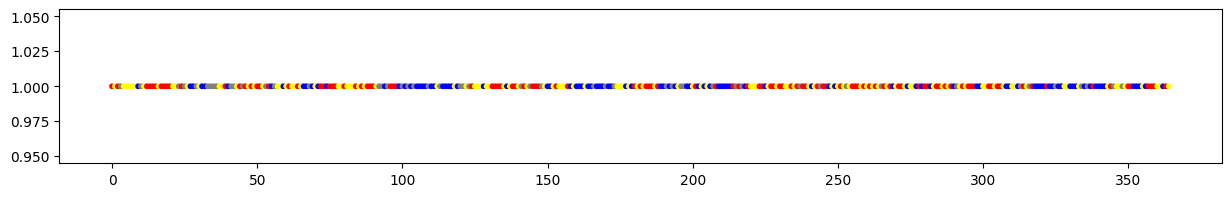

In [ ]:
state2color = {}
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

samples = weather.sample(365)
states = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(states, state2color)

sunny_colors = Random_Variable('sunny_colors', ['y', 'r', 'b', 'g'],
                              [0.4, 0.4, 0.1, 0.1])
cloudy_colors = Random_Variable('cloudy_colors', ['y', 'r', 'b', 'g'],
                               [0.1, 0.1, 0.6, 0.2])

def emit_sample(state, sunny_colors, cloudy_colors):
    if (state == 'S'):
        sample = sunny_colors.sample(1)[0]
    else:
        sample = cloudy_colors.sample(1)[0]
    return sample

samples = [emit_sample(s, sunny_colors, cloudy_colors) for s in states]
state2color = {}
state2color['y'] = 'yellow'
state2color['r'] = 'red'
state2color['b'] = 'blue'
state2color['g'] = 'grey'
plot_weather_samples(samples, state2color)

# Kalmam

In [ ]:
!pip install filterpy

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

# Chuyển đổi mảng 1D thành mảng 2D với một cột
samples_2d = np.expand_dims(emit_sample, axis=1)
samples


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
data_scaled = scaler.fit_transform(samples_2d)

# Chuyển đổi dữ liệu đã chuẩn hóa trở lại DataFrame
df_scaled = pd.DataFrame(data_scaled, index=samples.index, columns=samples_2d.columns)

# Hiển thị dữ liệu đã chuẩn hóa
print(df_scaled)

# Áp dụng bộ lọc Kalman cho từng cột dữ liệu
def apply_kalman_filter(data):
    measurements = data.values.reshape(-1, 1)  # Chuyển sang mảng 2D

    # Khởi tạo bộ lọc Kalman
    kf = KalmanFilter(dim_x=2, dim_z=1)

    # Định nghĩa các tham số của bộ lọc Kalman
    kf.F = np.array([[1., 1.],
                     [0., 1.]])  # Ma trận chuyển trạng thái
    kf.H = np.array([[1., 0.]])  # Ma trận quan sát
    kf.P *= 1000.  # Ma trận hiệp phương sai lỗi
    kf.R = 5       # Hiệp phương sai đo lường
    kf.Q = np.array([[0.1, 0.],
                     [0., 0.1]])  # Ma trận nhiễu quy trình

    # Định nghĩa trạng thái ban đầu
    kf.x = np.array([measurements[0], 0.])

    # Lưu trữ các giá trị ước lượng
    estimates = []

    # Áp dụng bộ lọc Kalman
    for measurement in measurements:
        kf.predict()
        kf.update(measurement)
        estimates.append(kf.x[0])

    return estimates

# Áp dụng bộ lọc Kalman cho tất cả các cột và vẽ đồ thị
plt.figure(figsize=(15, 10))

for column in df_scaled.columns:
    estimates = apply_kalman_filter(df_scaled[column])
    plt.plot(df_scaled.index, df_scaled[column], label=f'Measurements {column}')
    plt.plot(df_scaled.index, estimates, label=f'Kalman Filter Estimate {column}', linestyle='--')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Standardized Value')
plt.title('Kalman Filter Application on All Columns')
plt.show()


# HMM

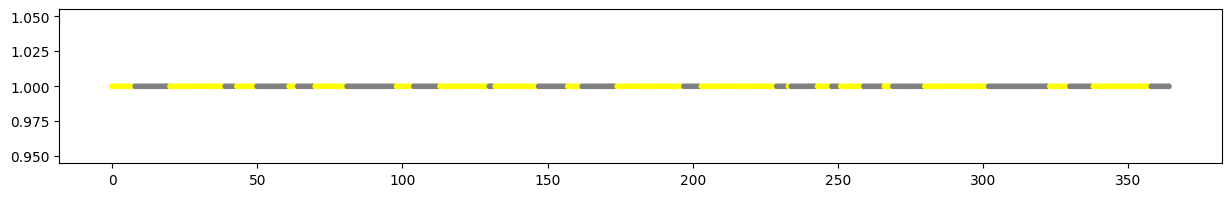

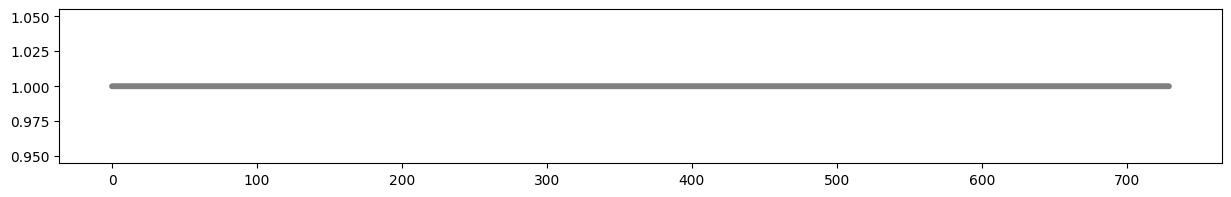

In [ ]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Ma trận chuyển trạng thái cho 2 trạng thái
transmat = np.array([[0.9, 0.1],
                     [0.1, 0.9]])

# Xác suất khởi đầu cho 2 trạng thái
start_prob = np.array([1.0, 0.0])

# Giá trị trung bình và hiệp phương sai của phân phối Gaussian cho 2 trạng thái
means = np.array([[25.0, 15.0],
                  [15.0, 25.0]])  # Giá trị trung bình nhiệt độ cho trời nắng và trời âm u
covars = np.tile(np.identity(2), (2, 1, 1))  # Ma trận hiệp phương sai đường chéo

# Tạo mô hình Gaussian HMM với 2 trạng thái
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1)
model.startprob_ = start_prob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

# Mô phỏng mô hình - X là các giá trị quan sát và Z là các trạng thái "ẩn"
X, Z = model.sample(365)

# Định nghĩa ánh xạ từ trạng thái đến màu sắc để vẽ biểu đồ
state2color = {0: 'yellow', 1: 'grey'}

# Hàm để vẽ mẫu thời tiết
# Hàm để vẽ mẫu thời tiết với xử lý lỗi
def plot_weather_samples(states, state2color):
    colors = []
    default_color = 'grey'  # Giá trị mặc định nếu không có ánh xạ cho trạng thái
    for state in states:
        try:
            color = state2color[state]
        except KeyError:
            color = default_color
        colors.append(color)
    plt.figure(figsize=(15, 2))
    plt.scatter(range(len(states)), [1] * len(states), c=colors, s=10)
    plt.show()

# Vẽ biểu đồ cho các mẫu thời tiết với xử lý lỗi
plot_weather_samples(Z, state2color)

# Gộp các mẫu
samples = [item for sublist in X for item in sublist]

# Cập nhật ánh xạ state2color cho các giá trị quan sát
state2color = {0: 'yellow', 1: 'red', 2: 'blue', 3: 'grey'}

# Vẽ biểu đồ cho các mẫu
plot_weather_samples(samples, state2color)
